### Standard LSTM based transformer model with random search hyperparameter tuning

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Add, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular


/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Preprocessed Dataset
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

# Define features and target variable
FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
            'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
            'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
            'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
            'active_power_rolling_mean', 'active_power_rolling_std']
TARGET = 'active_power'

In [3]:
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)  # Reshape for scaler and model

# Scale Features and Target
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [4]:
# Create Sequential Data for Transformer
time_steps = 3
features_dim = X_scaled.shape[1]

# Each sample consists of the previous "time_steps" rows as sequence input
X_seq = np.array([X_scaled[i-time_steps:i] for i in range(time_steps, len(X_scaled))])
y_seq = y_scaled[time_steps:]

In [5]:
# Split Data into Train/Validation/Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Define a Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    # Multi-head self-attention layer
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([inputs, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Position-wise feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    
    # Second skip connection and normalization
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Build Transformer Model for Hyperparameter Tuning
def build_transformer_model(hp: HyperParameters):
    inputs = Input(shape=(time_steps, features_dim))
    x = inputs
    
    # Tune number of transformer layers: 1 to 4 layers
    num_transformer_layers = hp.Int('num_transformer_layers', min_value=1, max_value=4, step=1)
    for i in range(num_transformer_layers):
        x = transformer_encoder(
            x,
            head_size=hp.Int(f'head_size_{i}', min_value=16, max_value=128, step=16),
            num_heads=hp.Int(f'num_heads_{i}', min_value=2, max_value=8, step=1),
            ff_dim=hp.Int(f'ff_dim_{i}', min_value=32, max_value=256, step=32),
            dropout=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        )
    
    # Convert sequence output to a fixed-length vector
    x = GlobalAveragePooling1D()(x)
    
    # Optional dense layer with dropout
    x = Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1))(x)
    
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
                  loss='mse', metrics=['mae', 'mape'])
    return model


In [7]:
# Initialize Keras Tuner (Random Search)
tuner = RandomSearch(
    build_transformer_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='fyp_logs',
    project_name='transformer_energy'
)

Reloading Tuner from fyp_logs/transformer_energy/tuner0.json


In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 20
num_transformer_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
head_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
num_heads_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
ff_dim_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'ma

In [9]:
# Hyperparameter Tuning
tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=1)

# Extract best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best validation loss:", tuner.oracle.get_best_trials(1)[0].score)
print("Best hyperparameters:", best_hps.values)

Trial 10 Complete [00h 49m 27s]
val_loss: 0.0013143490650691092

Best val_loss So Far: 0.0012711529270745814
Total elapsed time: 2d 07h 09m 20s
Best validation loss: 0.0012711529270745814
Best hyperparameters: {'num_transformer_layers': 4, 'head_size_0': 16, 'num_heads_0': 4, 'ff_dim_0': 64, 'dropout_0': 0.1, 'dense_units': 32, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.0003456954493337895, 'head_size_1': 16, 'num_heads_1': 2, 'ff_dim_1': 32, 'dropout_1': 0.0, 'head_size_2': 16, 'num_heads_2': 2, 'ff_dim_2': 32, 'dropout_2': 0.0, 'head_size_3': 16, 'num_heads_3': 2, 'ff_dim_3': 32, 'dropout_3': 0.0}


In [10]:
# Build Final Transformer Model with Optimal Hyperparameters
model_transformer = tuner.hypermodel.build(best_hps)
model_transformer.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 21)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 21)     │      5,589 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 3, 21)     │          0 │ input_layer_1[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3, 64)     │      1,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3, 21)     │      1,365 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 3, 21)     │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 21)     │      2,805 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3, 32)     │        704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3, 21)     │        693 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 3, 21)     │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 21)     │      2,805 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat

 Total params: 22,041 (86.10 KB)

 Trainable params: 22,041 (86.10 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define Callbacks: EarlyStopping & Learning Rate Reduction
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

In [12]:
# Train Final Transformer Model
history = model_transformer.fit(
    X_train, y_train,
    epochs=5000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 0.0127 - mae: 0.0459 - mape: 202.4806 - val_loss: 0.0015 - val_mae: 0.0192 - val_mape: 47.3347 - learning_rate: 3.4570e-04
Epoch 2/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - loss: 0.0017 - mae: 0.0221 - mape: 76.8496 - val_loss: 0.0014 - val_mae: 0.0163 - val_mape: 26.8667 - learning_rate: 3.4570e-04
Epoch 3/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.0017 - mae: 0.0212 - mape: 60.1191 - val_loss: 0.0014 - val_mae: 0.0192 - val_mape: 45.8893 - learning_rate: 3.4570e-04
Epoch 4/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - loss: 0.0017 - mae: 0.0208 - mape: 66.7967 - val_loss: 0.0013 - val_mae: 0.0153 - val_mape: 29.0079 - learning_rate: 3.4570e-04
Epoch 5/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 0.0017 - mae: 0.0207 - mape: 48.0554 - val_loss: 0.0014 - val_mae: 0.0169 - val_mape: 34.6994 - learning_rate: 3.4570e-04
Epoch 6/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/

In [13]:
# Evaluate the Model on the Test Set
loss = model_transformer.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Generate predictions
y_pred = model_transformer.predict(X_test)
# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute evaluation metrics
mse_val = mean_squared_error(y_test_original, y_pred_original)
mae_val = mean_absolute_error(y_test_original, y_pred_original)
r2_val = r2_score(y_test_original, y_pred_original)

print(f'Mean Squared Error (MSE): {mse_val}')
print(f'Mean Absolute Error (MAE): {mae_val}')
print(f'R-squared (R2): {r2_val}')


2838/2838 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0014 - mae: 0.0149 - mape: 26.5342
Test Loss: [0.0013747471384704113, 0.014737315475940704, 26.6378116607666]
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Mean Squared Error (MSE): 0.00137474745809638
Mean Absolute Error (MAE): 0.014737326101610528
R-squared (R2): 0.6896729727459215


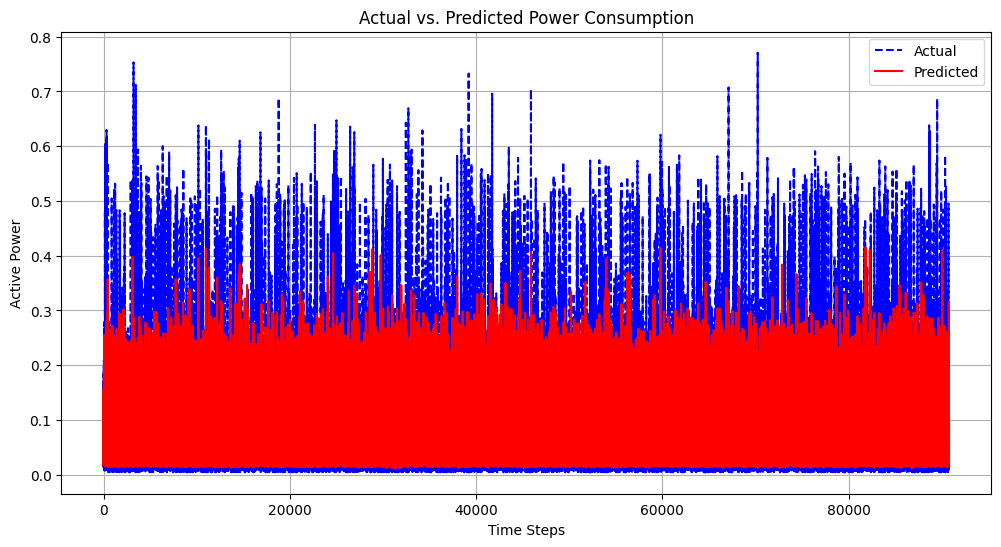

In [14]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Active Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid()
plt.show()

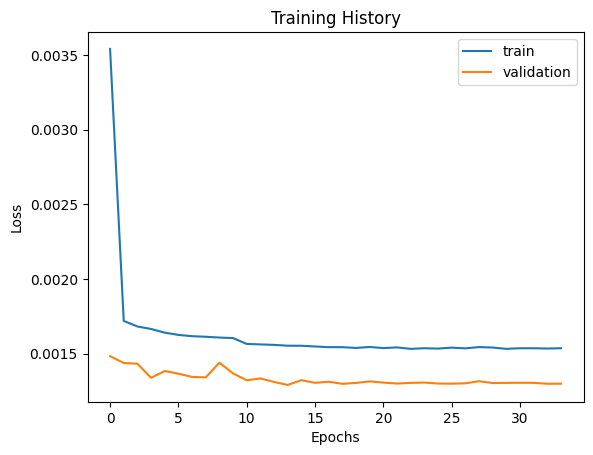

In [15]:
# Visualize training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()

In [16]:
features_dim = len(FEATURES)

In [17]:
# LIME Explanation for the LSTM Model

# Flatten the sequential data from (samples, time_steps, features) to (samples, time_steps*features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Generate feature names for flattened data: e.g., current_t1, voltage_t1, ...
feature_names_flat = []
for t in range(time_steps):
    for feature in FEATURES:
        feature_names_flat.append(f"{feature}_t{t+1}")

# Define a wrapper function that reshapes the flat data back to the sequential shape before predicting
def predict_wrapper(flat_data):
    n_samples = flat_data.shape[0]
    reshaped = flat_data.reshape(n_samples, time_steps, features_dim)  # Use features_dim instead of FEATURES
    preds = model_transformer.predict(reshaped)
    return preds.ravel()  # Return a 1D array

# Create a LimeTabularExplainer for regression
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

# Explain the prediction for one test instance (using the first instance as an example)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10  # Adjust to show top contributing features
)

# Display the LIME explanation
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except ImportError:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))

# Alternatively, print the explanation as text in the console
print("LIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")
    
# Save Lime explanation as HTML
lime_html = exp.as_html()   
with open('exp15_lime_explanation.html', 'w') as f:
    f.write(lime_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


LIME Explanation (Feature Contributions):
apparent_power_t3 <= 0.06: -0.0209
apparent_power_t2 <= 0.06: -0.0203
apparent_power_t1 <= 0.06: -0.0192
current_t2 <= 0.05: -0.0179
current_t1 <= 0.05: -0.0174
current_t3 <= 0.05: -0.0145
year_t1 <= 0.50: -0.0129
active_power_lag_1_t2 <= 0.05: 0.0099
active_power_lag_1_t3 <= 0.05: 0.0081
active_power_lag_1_t1 <= 0.05: 0.0076


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 10%|█         | 1/10 [00:09<01:29,  9.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 20%|██        | 2/10 [00:18<01:14,  9.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 30%|███       | 3/10 [00:27<01:04,  9.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 40%|████      | 4/10 [00:37<00:57,  9.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 50%|█████     | 5/10 [00:48<00:49,  9.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 60%|██████    | 6/10 [00:59<00:40, 10.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 70%|███████   | 7/10 [01:09<00:30, 10.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 80%|████████  | 8/10 [01:19<00:20, 10.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 90%|█████████ | 9/10 [01:30<00:10, 10.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


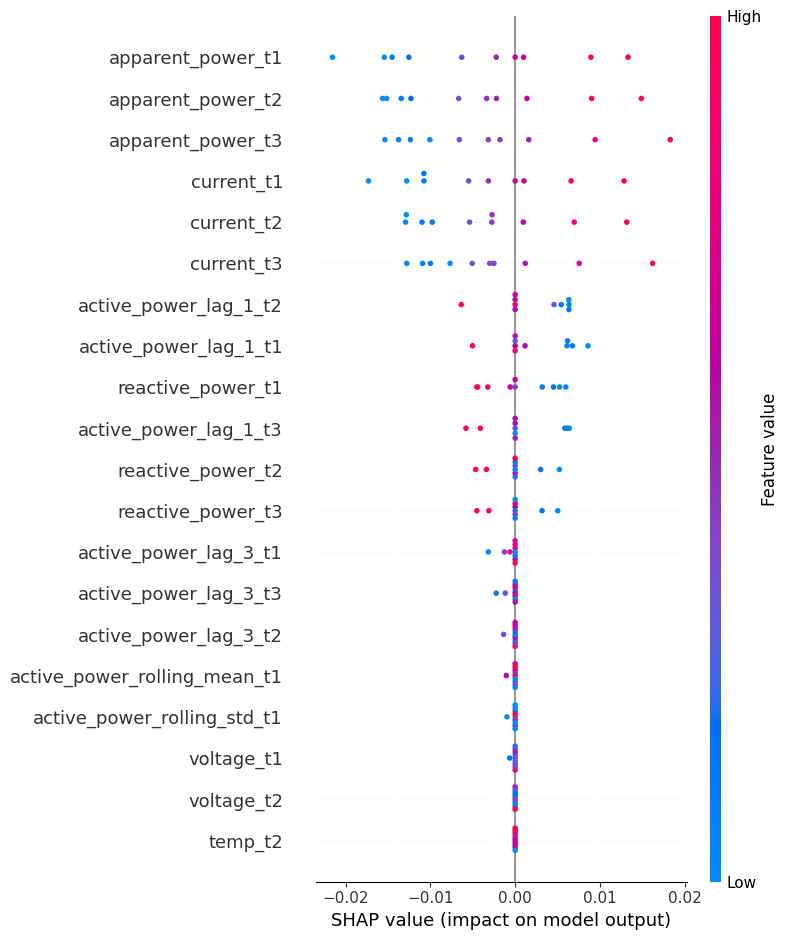

In [18]:
# Define a prediction wrapper
def predict_shap(data):
    # Reshape the flat data back to the original shape (samples, time_steps, features)
    reshaped_data = data.reshape(data.shape[0], time_steps, features_dim)
    return model_transformer.predict(reshaped_data).flatten()

# Use a subset of X_train for the explainer
explainer = shap.KernelExplainer(predict_shap, X_train[:100].reshape(100, -1))  # Flatten for KernelExplainer

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test[:10].reshape(10, -1))  # Flatten for KernelExplainer

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test[:10].reshape(10, -1), feature_names=feature_names_flat)

In [19]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Add, LayerNormalization, GlobalAveragePooling1D
# from tensorflow.keras.layers import MultiHeadAttention
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras_tuner import RandomSearch, HyperParameters
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.initializers import Orthogonal
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import matplotlib.pyplot as plt

# # -------------------------------
# # Load Preprocessed Dataset
# # -------------------------------
# df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

# # Define features and target variable
# FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
#             'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
#             'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
#             'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
#             'active_power_rolling_mean', 'active_power_rolling_std']
# TARGET = 'active_power'

# X = df[FEATURES].values
# y = df[TARGET].values.reshape(-1, 1)  # Reshape for scaler and model

# # -------------------------------
# # Scale Features and Target
# # -------------------------------
# scaler_x = MinMaxScaler()
# X_scaled = scaler_x.fit_transform(X)
# scaler_y = MinMaxScaler()
# y_scaled = scaler_y.fit_transform(y)

# # -------------------------------
# # Create Sequential Data for Transformer
# # -------------------------------
# time_steps = 3
# features_dim = X_scaled.shape[1]

# # Each sample consists of the previous "time_steps" rows as sequence input
# X_seq = np.array([X_scaled[i-time_steps:i] for i in range(time_steps, len(X_scaled))])
# y_seq = y_scaled[time_steps:]

# # -------------------------------
# # Split Data into Train/Validation/Test Sets
# # -------------------------------
# X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # -------------------------------
# # Define a Transformer Encoder Block
# # -------------------------------
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
#     # Multi-head self-attention layer
#     attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
#     x = Add()([inputs, attention_output])
#     x = LayerNormalization(epsilon=1e-6)(x)
    
#     # Position-wise feed-forward network
#     ff_output = Dense(ff_dim, activation='relu')(x)
#     ff_output = Dense(inputs.shape[-1])(ff_output)
#     ff_output = Dropout(dropout)(ff_output)
    
#     # Second skip connection and normalization
#     x = Add()([x, ff_output])
#     x = LayerNormalization(epsilon=1e-6)(x)
#     return x

# # -------------------------------
# # Build Transformer Model for Hyperparameter Tuning
# # -------------------------------
# def build_transformer_model(hp: HyperParameters):
#     inputs = Input(shape=(time_steps, features_dim))
#     x = inputs
    
#     # Tune number of transformer layers: 1 to 4 layers
#     num_transformer_layers = hp.Int('num_transformer_layers', min_value=1, max_value=4, step=1)
#     for i in range(num_transformer_layers):
#         x = transformer_encoder(
#             x,
#             head_size=hp.Int(f'head_size_{i}', min_value=16, max_value=128, step=16),
#             num_heads=hp.Int(f'num_heads_{i}', min_value=2, max_value=8, step=1),
#             ff_dim=hp.Int(f'ff_dim_{i}', min_value=32, max_value=256, step=32),
#             dropout=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
#         )
    
#     # Convert sequence output to a fixed-length vector
#     x = GlobalAveragePooling1D()(x)
    
#     # Optional dense layer with dropout
#     x = Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu')(x)
#     x = Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1))(x)
    
#     outputs = Dense(1, activation='linear')(x)
    
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
#                   loss='mse', metrics=['mae', 'mape'])
#     return model

# # -------------------------------
# # Initialize Keras Tuner (Random Search)
# # -------------------------------
# tuner = RandomSearch(
#     build_transformer_model,
#     objective='val_loss',
#     max_trials=30,
#     executions_per_trial=3,
#     directory='fyp_logs',
#     project_name='transformer_energy'
# )

# tuner.search_space_summary()

# # -------------------------------
# # Hyperparameter Tuning
# # -------------------------------
# tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# # Extract best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Best validation loss:", tuner.oracle.get_best_trials(1)[0].score)
# print("Best hyperparameters:", best_hps.values)

# # -------------------------------
# # Build Final Transformer Model with Optimal Hyperparameters
# # -------------------------------
# model_transformer = tuner.hypermodel.build(best_hps)
# model_transformer.summary()

# # -------------------------------
# # Define Callbacks: EarlyStopping & Learning Rate Reduction
# # -------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

# # -------------------------------
# # Train Final Transformer Model
# # -------------------------------
# history = model_transformer.fit(
#     X_train, y_train,
#     epochs=5000,
#     batch_size=32,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# # -------------------------------
# # Evaluate the Model on the Test Set
# # -------------------------------
# loss = model_transformer.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')

# # Generate predictions
# y_pred = model_transformer.predict(X_test)
# # Convert predictions back to original scale
# y_pred_original = scaler_y.inverse_transform(y_pred)
# y_test_original = scaler_y.inverse_transform(y_test)

# # Compute evaluation metrics
# mse_val = mean_squared_error(y_test_original, y_pred_original)
# mae_val = mean_absolute_error(y_test_original, y_pred_original)
# r2_val = r2_score(y_test_original, y_pred_original)

# print(f'Mean Squared Error (MSE): {mse_val}')
# print(f'Mean Absolute Error (MAE): {mae_val}')
# print(f'R-squared (R2): {r2_val}')


# ##########################################################################
# # SHAP Explanation for Transformer Model
# ##########################################################################
# import shap
# # Use a subset of the training data as background for better performance
# background_idx = np.random.choice(X_train.shape[0], 100, replace=False)
# background = X_train[background_idx]

# # Create a DeepExplainer using the transformer model and background data
# explainer_shap = shap.DeepExplainer(model_transformer, background)
# # Compute SHAP values for the test set
# shap_values = explainer_shap.shap_values(X_test)

# # Because our input is sequential (samples, time_steps, features), we average over time_steps
# shap_values_avg = np.mean(shap_values[0], axis=1)  # shape: (samples, features)
# X_test_avg = np.mean(X_test, axis=1)

# # Generate a summary plot. Feature names come from the original FEATURES list.
# shap.summary_plot(shap_values_avg, X_test_avg, feature_names=FEATURES)


# ##########################################################################
# # LIME Explanation for Transformer Model
# ##########################################################################
# import lime
# import lime.lime_tabular

# # Flatten the sequential data: shape from (samples, time_steps, features) to (samples, time_steps*features)
# X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_test_flat = X_test.reshape(X_test.shape[0], -1)

# # Create corresponding feature names: e.g. current_t1, voltage_t1, ... current_t3, voltage_t3, etc.
# feature_names_flat = []
# for t in range(time_steps):
#     for feature in FEATURES:
#         feature_names_flat.append(f"{feature}_t{t+1}")

# # Define a predict wrapper that reshapes flat data back to sequential form before predicting
# def predict_wrapper(flat_data):
#     n_samples = flat_data.shape[0]
#     reshaped = flat_data.reshape(n_samples, time_steps, features_dim)
#     preds = model_transformer.predict(reshaped)
#     return preds.ravel()  # Return as a 1D array

# # Create a LimeTabularExplainer for regression
# lime_explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=X_train_flat,
#     feature_names=feature_names_flat,
#     mode='regression'
# )

# # Explain a prediction for one instance from the test set (e.g., the first instance)
# i = 0
# exp = lime_explainer.explain_instance(
#     data_row=X_test_flat[i],
#     predict_fn=predict_wrapper,
#     num_features=10  # Display the top 10 features
# )

# # Display the LIME explanation in the notebook (if possible); otherwise print as HTML/text
# try:
#     exp.show_in_notebook(show_table=True, show_all=False)
# except ImportError:
#     from IPython.display import display, HTML
#     display(HTML(exp.as_html()))

# # Also print the explanation as a list in the terminal
# print("LIME Explanation (Feature contributions):")
# for feature, weight in exp.as_list():
#     print(f"{feature}: {weight:.4f}")

# # Ensure that matplotlib plots (e.g., SHAP summary) are rendered
# plt.show()
